In [ ]:
<a href="https://colab.research.google.com/github/dora-jpg/Vaccine-Sentiment-Classifier/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Intelligence II - Homework 4
# 💉Vaccine sentiment classifier with fine-tuning BERT.

In this exercise we are going to develop a vaccine sentiment classifier that classifies tweets in pro-vax, anti-vax and neutral classes by fine-tuning BERT.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Read Datasets

Import libraries that will be used in this notebook, define a seeding function and set device to cuda if available.


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

import numpy as np
import pandas as pd
import math

# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image
import time

# for text preprocessing
import re
import string

# Learning curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

!CUBLAS_WORKSPACE_CONFIG=:4096:2 # for cuda deterministic behavior

######### BERT ############
# first install transformers from hugging face
!pip install transformers

# imports
from transformers import BertTokenizerFast
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel

# dataloaders 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(False)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Working on:', device)

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 32.7 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 24.1 MB/s 
     |████████████████████████████████| 895 kB 39.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Working on: cuda


Read train and validation datasets.

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_train_set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_validation_set.csv")

 We don't need the first column of the datasets because it is an index.

In [4]:
# get rid of first column
df_train = df_train.iloc[: , 1:]
df_test = df_test.iloc[: , 1:]

In [5]:
display(df_train.head())

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [6]:
display(df_test.head())

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2


# Data Pre-processing

## Overview of label distribution

In [ ]:
print("train data")
print("label 0:",df_train['label'][df_train['label'] == 0].count())
print("label 1:",df_train['label'][df_train['label'] == 1].count())
print("label 2:",df_train['label'][df_train['label'] == 2].count())
print("validation data")
print("label 0:",df_test['label'][df_test['label'] == 0].count())
print("label 1:",df_test['label'][df_test['label'] == 1].count())
print("label 2:",df_test['label'][df_test['label'] == 2].count())

train data
label 0: 7458
label 1: 2073
label 2: 6445
validation data
label 0: 1065
label 1: 296
label 2: 921


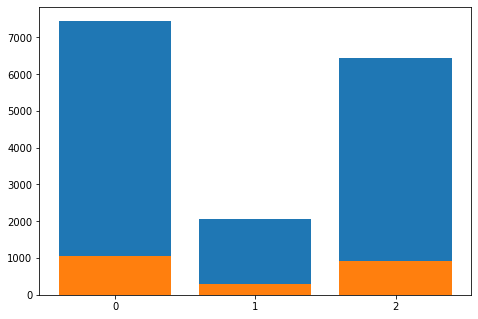

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['0', '1', '2']
train = [df_train['label'][df_train['label'] == 0].count(),df_train['label'][df_train['label'] == 1].count(),df_train['label'][df_train['label'] == 2].count()]
test= [df_test['label'][df_test['label'] == 0].count(),df_test['label'][df_test['label'] == 1].count(),df_test['label'][df_test['label'] == 2].count()]
ax.bar(labels, train)
ax.bar(labels, test)
plt.show()

Label 1 has very few instances so we expect that it has a lower score than the other 2 labels. 

## Data Cleaning


Cleaning involves removal of urls, html tags and mentions (@name). BERT was trained with whole sentences, including punctuation so the preprocessing here is pretty simple. 

In [7]:
def tweets_cleaning(x):
    x = x.lower().strip()
    # romove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    x = url.sub(r'',x)
    # remove html tags
    html = re.compile(r'<.*?>')
    x = html.sub(r'',x)
    # Remove '@name'
    x = re.sub(r'(@.*?)[\s]', ' ', x)

    return x

df_train['clean_tweet'] = df_train['tweet'].apply(tweets_cleaning)
df_test['clean_tweet'] = df_test['tweet'].apply(tweets_cleaning)

# BERT

## Tokenization

Get BERT Tokinizer. I use the BertTokenizerFast. 

From [Hugging Face Tokenizer documention](https://huggingface.co/docs/transformers/main_classes/tokenizer):

> A tokenizer is in charge of preparing the inputs for a model. The library contains tokenizers for all the models. Most of the tokenizers are available in two flavors: a full python implementation and a “Fast” implementation based on the Rust library 🤗 Tokenizers. The “Fast” implementations allows:
* a significant speed-up in particular when doing batched tokenization and
* additional methods to map between the original string (character and words) and the token space (e.g. getting the index of the token comprising a given character or the span of characters corresponding to a given token).



In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Pad or truncate all tweets to `seq_len`.

In [9]:
seq_len = 61

train_en = tokenizer(df_train['clean_tweet'].to_list(),
                    padding = 'max_length',
                    max_length=seq_len, # pad and truncate to this length
                    truncation=True,
                    return_tensors = 'pt') # return pytorch tensors

val_en = tokenizer(df_test['clean_tweet'].to_list(),
                   padding = 'max_length',
                   max_length=seq_len, # pad and truncate to this length
                   truncation=True,
                   return_tensors = 'pt') # return pytorch tensors

Create the dataloaders.

In [10]:
batch_size = 16

train_dataset = TensorDataset(train_en['input_ids'], train_en['attention_mask'], torch.tensor(df_train['label']))
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_en['input_ids'], val_en['attention_mask'], torch.tensor(df_test['label']))
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

The model consists of the BERT, a single linear layer and a Softmax. 

In [11]:
class BertForSentimentClassification(nn.Module):
    def __init__(self):
        super(BertForSentimentClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
        D_in = 768
        D_out = 3
        self.linear = nn.Linear(D_in, D_out)
        self.softmax = nn.Softmax(dim=1)
         
    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # hidden_states = outputs[2] # get hidden states: shape 
        # token_embeddings = torch.stack(hidden_states, dim=0) # stack all hidden states
                                                            # [layers, batch, seq_len, hidden]
        # print(token_embeddings.size())
        # cls_embedding = token_embeddings[:, :, 0, :] # get cls emb [layers, batch, hidden]
        # print(cls_embedding.size())
        
        # concat the last 4 layers: [batch, hidden*4]
        # concat_last_4_hidden_state_cls = torch.cat((cls_embedding[-1], 
        #                                                cls_embedding[-2],
        #                                                cls_embedding[-3],
        #                                                cls_embedding[-4]),
        #                                               dim=1)
        #
        # avg_last_4_hidden_state_cls = torch.mean(cls_embedding[-4:],
        #                                         dim=0)
        # print(avg_last_4_hidden_state_cls.size())

        # use the last hidden state of [CLS] for classification
        last_hidden_state_cls = outputs[0][:, 0, :]
        
        logits = self.linear(last_hidden_state_cls) # [batch, num_classes]
        scores = self.softmax(logits) # probabilities distribution

        return scores

## Fine-Tune

Train the model and evaluate it on the validation dataset for each epoch.

In [12]:
from tqdm import tqdm

def train():
    epoch_loss = []
    validation_loss = []
    f1_scores = []
    for epoch in range(epochs):
        model.train()
        batch_loss = []
        progress_bar = tqdm(train_dataloader, colour = 'MAGENTA', leave=True, position=0)
        progress_bar.set_description(f'Epoch {epoch+1}')

        for batch in progress_bar:
            model.zero_grad()

            input_ids, masks, labels = tuple(t.to(device) for t in batch)
            scores = model(input_ids, masks)           

            loss = loss_func(scores, labels)
            batch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # to prevent exploding gradients
            optimizer.step()           

            progress_bar.set_postfix(loss=loss.item()) # update loss in progress bar

        epoch_loss.append(sum(batch_loss)/len(train_dataloader))

        # evaluate on validation dataset
        model.eval()

        total_scores = torch.empty((0,3)).to(device=device)
        total_labels = torch.empty((0)).to(device=device)

        batch_loss = []
        with torch.no_grad():
            for test_batch in val_dataloader:
                input_ids, masks, labels = tuple(t.to(device) for t in test_batch)

                scores = model(input_ids, masks)
                
                total_scores = torch.concat((total_scores, scores), 0)
                total_labels = torch.concat((total_labels, labels), 0)

                loss = loss_func(scores, labels)

                batch_loss.append(loss.item())

            validation_loss.append(sum(batch_loss)/len(val_dataloader))
        
        _, y_pred = total_scores.max(1)

        if device==torch.device("cuda"):
            y_pred =  y_pred.cpu()
            total_labels = total_labels.cpu()

        f1score = f1_score(total_labels, y_pred, average='micro')
        f1_scores.append(f1score)
        
        print(f"train loss={epoch_loss[epoch]:.5f} validation loss={validation_loss[epoch]:.5f} f1={f1score:.5f}")
        print("\n")
    
    return epoch_loss, validation_loss, f1_scores

In [13]:
set_seed(1234)

model = BertForSentimentClassification()
model.to(device)

epochs  = 4

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

epoch_loss, validation_loss, _ = train()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch 1: 100%|██████████| 999/999 [06:48<00:00,  2.45it/s, loss=0.559]


train loss=0.85608 validation loss=0.81542 f1=0.72393




Epoch 2: 100%|██████████| 999/999 [06:48<00:00,  2.44it/s, loss=0.801]


train loss=0.77773 validation loss=0.78762 f1=0.75329




Epoch 3: 100%|██████████| 999/999 [06:48<00:00,  2.45it/s, loss=0.687]


train loss=0.73439 validation loss=0.77588 f1=0.77257




Epoch 4: 100%|██████████| 999/999 [06:48<00:00,  2.44it/s, loss=0.685]


train loss=0.70278 validation loss=0.76996 f1=0.77739




# Evaluate

In [14]:
def f1(model, test_loader):
    model.eval()
    total_scores = torch.empty((0,3)).to(device=device)
    total_labels = torch.empty((0)).to(device=device)

    with torch.no_grad():
        for test_batch in test_loader:
            input_ids, masks, labels = tuple(t.to(device) for t in test_batch)

            scores = model(input_ids, masks)

            total_scores = torch.concat((total_scores, scores), 0)
            total_labels = torch.concat((total_labels, labels), 0)
                    
    _, y_pred = total_scores.max(1)

    if device==torch.device("cuda"):
        y_pred =  y_pred.cpu()
        total_labels = total_labels.cpu()

    print("")
    precision, recall, f1, support = precision_recall_fscore_support(total_labels, y_pred)
    print(f"         precision\t  recall\t   f1\t    \tsupport")
    print(f"--------------------------------------------------------------")
    print(f"label 0 | {precision[0]*100:0.4f}\t {recall[0]*100:0.4f}\t {f1[0]*100:0.4f}\t {support[0]}")
    print(f"label 1 | {precision[1]*100:0.4f}\t {recall[1]*100:0.4f}\t {f1[1]*100:0.4f}\t {support[1]}")
    print(f"label 2 | {precision[2]*100:0.4f}\t {recall[2]*100:0.4f}\t {f1[2]*100:0.4f}\t {support[2]}")

    average = precision_recall_fscore_support(total_labels, y_pred, average='micro')
    print(f"micro   | {average[0]*100:0.4f}\t {average[1]*100:0.4f}\t {average[2]*100:0.4f}\t -")

    return y_pred, total_scores

In [15]:
y_pred, scores = f1(model, val_dataloader)


         precision	  recall	   f1	    	support
--------------------------------------------------------------
label 0 | 83.3333	 82.6291	 82.9797	 1065
label 1 | 65.3992	 58.1081	 61.5385	 296
label 2 | 74.9740	 78.3931	 76.6454	 921
micro   | 77.7388	 77.7388	 77.7388	 -


Overall scores are better. Label 1 which is the class with the least examples has improved a lot.

### Confusion Matrix

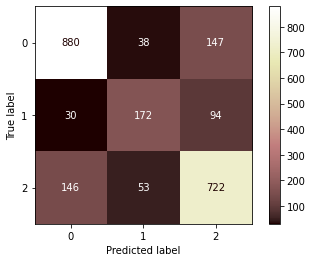

In [16]:
ConfusionMatrixDisplay.from_predictions(df_test['label'], y_pred, cmap=plt.cm.pink)  
plt.show()

### Learning Curves

[0.8560798792867689, 0.7777286551974796, 0.7343879222153902, 0.7027791561903777]
[0.8154246181874842, 0.787615971548574, 0.7758815659509672, 0.7699637738141146]


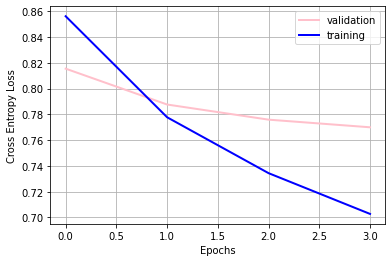

In [17]:
# plot
print(epoch_loss)
print(validation_loss)
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), validation_loss, color="pink", lw=2, label='validation')
ax.plot(np.arange(epochs), epoch_loss, color="b", lw=2, label='training')

ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

ax.grid()
ax.legend(loc=0)
plt.show()
  

### ROC Curve

[[1.85403464e-04 9.58121657e-01 4.16929200e-02]
 [9.99916315e-01 4.56737907e-05 3.80188649e-05]
 [9.99965787e-01 1.90653409e-05 1.50928327e-05]
 ...
 [6.15530516e-05 4.82538708e-05 9.99890208e-01]
 [1.17305408e-05 4.60595620e-05 9.99942303e-01]
 [9.99871969e-01 2.29547422e-05 1.04986924e-04]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


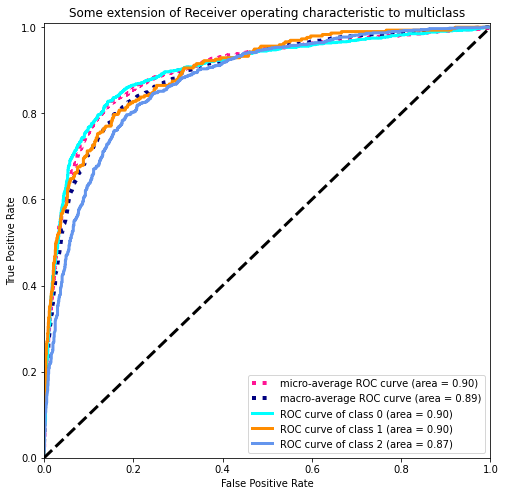

In [18]:
# CODE FROM https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

if device==torch.device("cuda"):
  y_score = scores.detach().cpu().numpy()
else:
  y_score = scores.detach().numpy()
print(y_score)
y_test_roc = np.array(pd.get_dummies(df_test['label']))
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
################################################################################

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

As we can see from the plots, the model does not overfit, has a better f1 score and ROC curves from any previous models. It learns better the class with label 1 (as we can see on the confusion matrix and the class f1 score).